In [1]:
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be upgraded:
  libcudnn8
1 upgraded, 0 newly installed, 1 to remove and 30 not upgraded.
Need to get 430 MB of archives.
After this operation, 3,139 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  libcudnn8 8.1.0.77-1+cuda11.2 [430 MB]
Fetched 430 MB in 8s (51.7 MB/s)
(Reading database ... 155685 files and directories currently installed.)
Removing libcudnn8-dev (8.0.5.39-1+cuda11.1) ...
(Reading database ... 155663 files and directories currently installed.)
Preparing to unpack .../libcudnn8_8.1.0.77-1+cuda11.2_amd64.deb ...
Unpacking libcudnn8 (8.1.0.77-1+c

In [ ]:
!pip install -U tensorflow tensorflow_datasets

In [130]:
import os
import pathlib

import matplotlib.pyplot as plt
from IPython import display

import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator


#Set seed value for reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## Import the `Spectograms dataset`

In [4]:
DATASET_PATH = '/content/spectograms'

data_dir = pathlib.Path(DATASET_PATH)

if not data_dir.exists():
  tf.keras.utils.get_file(
      'spectograms_2.zip',
      origin = "https://debonair-sa.s3.af-south-1.amazonaws.com/datasets/spectograms_2.zip",
      extract = True, 
      cache_dir = '.'
      )

736054096/736054096 [==============================] - 72s 0us/step


In [8]:
data_dir = '/content/spectograms_final'

In [9]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))

print(f'Commands: {commands}')

Commands: ['kumi' 'tatu' 'moja' 'mbili' 'sita' 'saba' 'tisa' 'tano' 'ndio' 'nane'
 'nne' 'hapana']


#### The audio clips are 1 second or less at 16kHz. The `output_seqence_length = 16_000` pads the short ones to exactly 1 second (and would trim longer ones) so that they can easily be batched.

In [11]:
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    directory = data_dir, 
    batch_size = 64, 
    shuffle = True,
    validation_split = 0.2, 
    seed = 0,
    subset = 'both'
)

label_names = np.array(train_ds.class_names)
print('Label names: ', label_names)

Found 4200 files belonging to 12 classes.
Using 3360 files for training.
Using 840 files for validation.
Label names:  ['hapana' 'kumi' 'mbili' 'moja' 'nane' 'ndio' 'nne' 'saba' 'sita' 'tano'
 'tatu' 'tisa']


In [12]:
train_ds.element_spec

(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

The `utils.audio_dataset_from_directory` function only returns up to 2 splits. It is a good idea to keep a test set separate from your validation set. You can use `Dataset.shard` to split the validation set into 2 halves.

In [13]:
test_ds = val_ds.shard(num_shards = 2, index = 0)
val_ds = val_ds.shard(num_shards = 2, index = 1)


for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 256, 256, 3)
(64,)


Visualize a few audio waveforms.

## Build and train model.
Add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model.

In [17]:
train_spectrogram_ds = train_ds.cache().shuffle(10_000).prefetch(tf.data.AUTOTUNE)
val_spectrograms_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrograms_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)

Your model will use the following preprocessing layers: 
- `tf.keras.layers.Resizing` to downsample the input to enable the model to train faster.
- `tf.keras.layers.Normalization` to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` memthod would first need to be called on the training data in order to compute aggergate statistics.

In [19]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

In [22]:
input_shape = example_spectrograms.shape[1:]
print('Input shape: ', input_shape)
num_labels = len(commands)

#Instantiate the tf.keras.layers.Normalization layer.
norm_layer = layers.Normalization()

#Fit the state oft the layer to the spectograms with `Normalization.adapt`
norm_layer.adapt(data = train_spectrogram_ds.map(map_func = lambda spec, label: spec))

inputs = layers.Input(shape = input_shape)

#Downsample the input.
x = layers.Resizing(32, 32)(inputs)

#Normalize.
x = norm_layer(x)
x = layers.Conv2D(32, 3, activation = 'relu')(x)
x = layers.Conv2D(64, 3, activation = 'relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Dropout(0.25)(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation = 'relu')(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(num_labels)(x)

model = tf.keras.Model(inputs, outputs)

model.summary()

Input shape:  (256, 256, 3)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 resizing_1 (Resizing)       (None, 32, 32, 3)         0         
                                                                 
 normalization_1 (Normalizat  (None, 32, 32, 3)        7         
 ion)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                           

In [23]:
#Compile model with Adam optimizer and cross-entropy loss.
model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = 'accuracy'
)

#Train the model over 10 epochs.
EPOCHS = 50
history = model.fit(
    train_spectrogram_ds, 
    validation_data = val_spectrograms_ds, 
    epochs = EPOCHS,
    callbacks = tf.keras.callbacks.EarlyStopping(verbose = 1, patience = 10)
)

Epoch 1/50
53/53 [==============================] - 2s 28ms/step - loss: 2.4607 - accuracy: 0.1461 - val_loss: 2.1537 - val_accuracy: 0.2832
Epoch 2/50
53/53 [==============================] - 1s 25ms/step - loss: 1.9480 - accuracy: 0.3262 - val_loss: 1.6906 - val_accuracy: 0.4133
Epoch 3/50
53/53 [==============================] - 1s 25ms/step - loss: 1.5617 - accuracy: 0.4670 - val_loss: 1.4890 - val_accuracy: 0.4847
Epoch 4/50
53/53 [==============================] - 1s 25ms/step - loss: 1.2548 - accuracy: 0.5720 - val_loss: 1.3315 - val_accuracy: 0.5306
Epoch 5/50
53/53 [==============================] - 1s 25ms/step - loss: 1.0134 - accuracy: 0.6664 - val_loss: 1.2409 - val_accuracy: 0.5740
Epoch 6/50
53/53 [==============================] - 1s 25ms/step - loss: 0.8461 - accuracy: 0.7232 - val_loss: 1.2102 - val_accuracy: 0.5714
Epoch 7/50
53/53 [==============================] - 1s 25ms/step - loss: 0.6717 - accuracy: 0.7729 - val_loss: 1.2259 - val_accuracy: 0.5995
Epoch 8/50
53

Text(0, 0.5, 'Accuracy [%]')

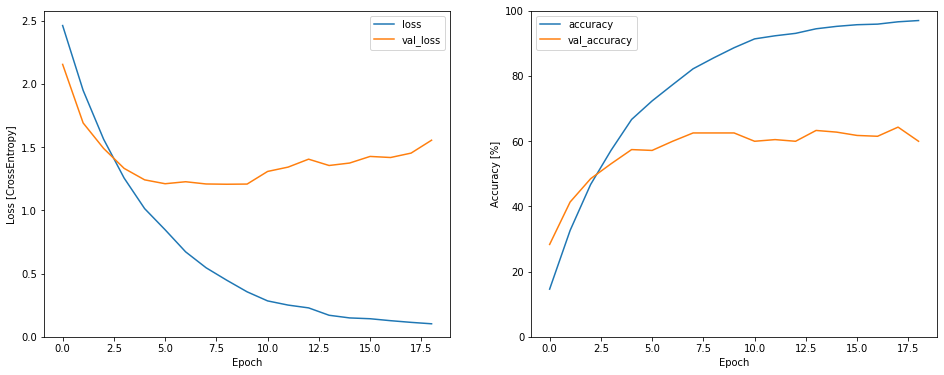

In [24]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

#### Evaluate model performance.

In [25]:
model.evaluate(test_spectrograms_ds, return_dict = True)

7/7 [==============================] - 5s 783ms/step - loss: 1.5853 - accuracy: 0.6250


{'loss': 1.5853203535079956, 'accuracy': 0.625}

#### Display a confusion matrix.

In [26]:
y_pred = model.predict(test_spectrograms_ds)
y_pred = tf.argmax(y_pred, axis = 1)

y_true = tf.concat(list(test_spectrograms_ds.map(lambda s, lab: lab)), axis = 0)

7/7 [==============================] - 0s 19ms/step


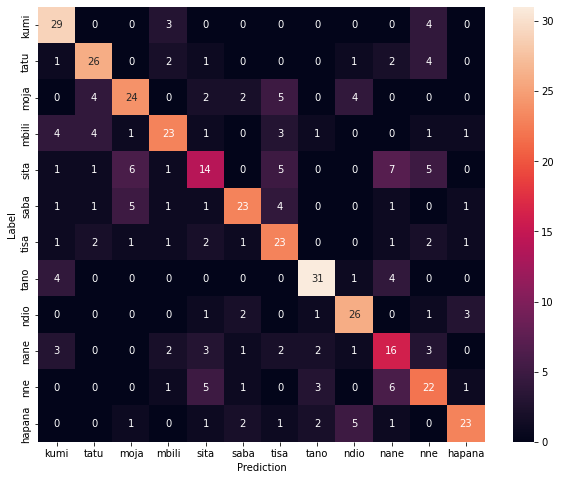

In [27]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)

plt.figure(figsize = (10, 8))
sns.heatmap(confusion_mtx, 
            xticklabels = commands,
            yticklabels = commands, 
            annot = True, fmt = 'g')

plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [28]:
import pandas as pd

train = pd.read_csv('/content/Train.csv')
test = pd.read_csv('/content/Test.csv')
sample_submission = pd.read_csv('/content/SampleSubmission.csv')

test.head()

,Word_id
0,id_jp2pxl0r84ya.wav
1,id_ndduqqvthbpx.wav
2,id_36oxymxfcm6q.wav
3,id_ue9b0to760pg.wav
4,id_prja4oprb914.wav


In [32]:
#Add specogram path to test set.
test['spec_name'] = [X.split('.')[0] + '.png' for X in test.Word_id]
test.head(2)

,Word_id,spec_name
0,id_jp2pxl0r84ya.wav,id_jp2pxl0r84ya.png
1,id_ndduqqvthbpx.wav,id_ndduqqvthbpx.png


In [33]:
!wget 'https://debonair-sa.s3.af-south-1.amazonaws.com/datasets/spectograms.zip'

--2022-09-13 12:51:41--  https://debonair-sa.s3.af-south-1.amazonaws.com/datasets/spectograms.zip
Resolving debonair-sa.s3.af-south-1.amazonaws.com (debonair-sa.s3.af-south-1.amazonaws.com)... 52.95.176.25
Connecting to debonair-sa.s3.af-south-1.amazonaws.com (debonair-sa.s3.af-south-1.amazonaws.com)|52.95.176.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1052228902 (1003M) [application/zip]
Saving to: ‘spectograms.zip’

spectograms.zip     100%[===================>]   1003M  10.3MB/s    in 1m 40s  

2022-09-13 12:53:23 (10.0 MB/s) - ‘spectograms.zip’ saved [1052228902/1052228902]



In [ ]:
!unzip '/content/spectograms.zip'

In [115]:
def prepare_test_set(path):
  image = tf.io.read_file(path)
  image = tf.image.decode_png(image, channels = 3)
  image = tf.image.resize(image, [256, 256])
  image = tf.cast(image, tf.float32)
  return image

In [110]:
test_images = []
for item in range(len(test)):
  test_image = test.iloc[item, 1]
  test_dir = '/content/spectograms/' + test_image
  test_dir = str(test_dir)
  test_images.append(test_dir)

In [119]:
# test_dataset = tf.data.Dataset.list_files(str(path_to_test_set/test['spec_name'].tolist()), shuffle = False)

test_dataset = tf.data.Dataset.from_tensor_slices(test_images)
test_dataset  = test_dataset.map(prepare_test_set, num_parallel_calls = tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size = 64)
test_dataset.element_spec

TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)

In [146]:
predictions = model.predict(test_dataset)
predictions = abs(predictions) / 100

29/29 [==============================] - 10s 358ms/step


In [147]:
predictions.shape

(1800, 12)

In [150]:
columns = train['Swahili_word'].unique().tolist()
submission[[columns]] = 0
submission.head()

,Word_id,Predictions,mbili,tatu,ndio,nne,nane,hapana,sita,tisa,moja,saba,tano,kumi
0,id_jp2pxl0r84ya.wav,8,0,0,0,0,0,0,0,0,0,0,0,0
1,id_ndduqqvthbpx.wav,11,0,0,0,0,0,0,0,0,0,0,0,0
2,id_36oxymxfcm6q.wav,10,0,0,0,0,0,0,0,0,0,0,0,0
3,id_ue9b0to760pg.wav,9,0,0,0,0,0,0,0,0,0,0,0,0
4,id_prja4oprb914.wav,9,0,0,0,0,0,0,0,0,0,0,0,0


In [172]:
word_id = pd.DataFrame({'Word_id' : test['Word_id']})
swahili_words = pd.DataFrame(predictions, columns = train.Swahili_word.unique())

new_df = word_id.join(swahili_words)
new_df.head()

,Word_id,mbili,tatu,ndio,nne,nane,hapana,sita,tisa,moja,saba,tano,kumi
0,id_jp2pxl0r84ya.wav,0.103308,0.007413,0.066636,0.064769,0.065224,0.086192,0.039909,0.047595,0.110706,0.053632,0.019226,0.067004
1,id_ndduqqvthbpx.wav,0.091722,0.071763,0.059589,0.030508,0.094365,0.028644,0.038527,0.022767,0.073281,0.023760,0.033721,0.162237
2,id_36oxymxfcm6q.wav,0.125980,0.151889,0.086176,0.072189,0.067100,0.067337,0.133466,0.064596,0.064570,0.101045,0.120998,0.097822
3,id_ue9b0to760pg.wav,0.038673,0.067965,0.118830,0.014584,0.031960,0.031061,0.095206,0.044682,0.034521,0.091088,0.038179,0.016840
4,id_prja4oprb914.wav,0.020287,0.022206,0.034969,0.024906,0.008547,0.015603,0.043812,0.005023,0.013969,0.052198,0.035081,0.038497


In [173]:
new_df.to_csv('/content/second_submission.csv', index = False)